In [1]:
import sys
sys.path.insert(0, './main')
from regcoil import *
import avg_laplace_force
from tqdm import tqdm
from vector_field_on_TS import *
from multiprocessing import Pool
import math
%matplotlib inline

In [2]:
from matplotlib import colors
plt.rcParams['figure.figsize'] = [15, 16]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
def plot_jupyter(fig, axs,lst_data,lst_title,suptitle,cmap="jet",vmin=None):
    fig.suptitle(suptitle)

    images = []
    for i in range(len(axs)):
        data = lst_data[i]
        images.append(axs[i].imshow(data, cmap=cmap, origin='lower'))
        axs[i].label_outer()
        axs[i].set_title(lst_title[i])
        axs[i].text(0,0,'max = {:.2E}'.format(np.max(data.flatten())))

    # Find the min and max of all colors for use in setting the color scale.
    if vmin is None:
        vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    #norm = colors.Normalize(vmin=vmin, vmax=vmax)
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    #fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)
    fig.colorbar(images[0], ax=axs,fraction=.1)

    # Make images respond to changes in the norm of other images (e.g. via the
    # "edit axis, curves and images parameters" GUI on Qt), but be careful not to
    # recurse infinitely!
    def update(changed_image):
        for im in images:
            if (changed_image.get_cmap() != im.get_cmap()
                    or changed_image.get_clim() != im.get_clim()):
                im.set_cmap(changed_image.get_cmap())
                im.set_clim(changed_image.get_clim())


    for im in images:
        im.callbacksSM.connect('changed', update)

def compute_aux(cws,laplace_array):
    laplace_norm=np.linalg.norm(laplace_array,axis=2)
    laplace_normal=np.sum(-1*cws.normal[:-1,:-1,:]*laplace_array,axis=2)
    laplace_tangent=laplace_array-laplace_normal[:,:,np.newaxis]*(-1*cws.normal[:-1,:-1,:])
    laplace_norm_tangent=np.linalg.norm(laplace_tangent,axis=2)
    return [laplace_norm,laplace_normal,laplace_tangent,laplace_norm_tangent]
def compute_L_eps(cws,coeff,eps):
    import importlib
    importlib.reload(avg_laplace_force)
    avg=avg_laplace_force.Avg_laplace_force(cws)
    return avg.L_eps_optimized(coeff,eps)

In [3]:
Np=3
ntheta_plasma = 64+1
ntheta_coil   = 64+1
nzeta_plasma = 64+1
nzeta_coil   = 64+1
mpol_coil  = 8 #probably not enough
ntor_coil  = 8 #probably not enough
net_poloidal_current_Amperes = 11884578.094260072/Np
net_toroidal_current_Amperes = 0.
curpol=4.9782004309255496
lamb1=1.2e-14
lamb2=2.5e-16
lamb3=5.1e-19
lamb=lamb3
gamma=lamb2

In [4]:
def cost(coeff_l):
    #to check compatibility
    sol_C,sol_S=vector_field_on_TS.Div_free_vector_field_on_TS.array_coeff_to_CS(coeff_l,phisize)
    b_array=get_bnorm(path_bnorm,plasma_surf)
    b_vec=-curpol*(b_array[:-1,:-1]).flatten()
    err_B=(div_free.compute_normal_B(plasma_surf,(G,I,sol_C,sol_S))-b_vec)
    surf_err=np.mean(err_B*err_B*plasma_surf.dS[:-1,:-1].flatten())*plasma_surf.Np
    j=vector_field_on_TS.get_full_j(sol_C,sol_S,div_free.surf.dpsidu,div_free.surf.dpsidv,div_free.surf.dS,div_free.surf.grid,G,I)
    norm_j=np.linalg.norm(j,axis=2)[:-1,:-1]
    err_j=np.mean(norm_j*norm_j*div_free.surf.dS[:-1,:-1])*cws.Np
    coeff=(G,I,sol_C,sol_S)
    laplace_array=avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)
    error2=np.linalg.norm(laplace_array,axis=2)**2
    avg_Laplace=np.sum(error2*cws.dS[:-1,:-1])/((cws.lu-1)*(cws.lv-1))*cws.Np
    err_tot=surf_err+lamb*err_j+gamma*avg_Laplace
    print('cost : surface error = {:.5E} ,\n j norm = {:.5E} \n Laplace norm = {:.5E}\n total cost = {:.5E}'.format(surf_err,err_j,avg_Laplace,err_tot))
    return (np.reshape(err_B,(plasma_surf.lu-1,plasma_surf.lv-1)))

In [5]:
phisize=(ntor_coil,mpol_coil)
G,I=net_poloidal_current_Amperes,net_toroidal_current_Amperes
path_plasma='li383/plasma_surf.txt'
path_cws='li383/cws.txt'
path_bnorm='li383/bnorm.txt'
plasma_surf=toroidal_surface.Toroidal_surface(W7x_pathfile=path_plasma,nbpts=(ntheta_plasma,nzeta_plasma),Np=3)
cws=toroidal_surface.Toroidal_surface(W7x_pathfile=path_cws,nbpts=(ntheta_coil,nzeta_coil),Np=3)
div_free=vector_field_on_TS.Div_free_vector_field_on_TS(cws)
avg=avg_laplace_force.Avg_laplace_force(cws)

In [6]:
sol1,div_free=Regcoil(G,I,lamb1,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)
sol2,div_free=Regcoil(G,I,lamb2,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)
sol3,div_free=Regcoil(G,I,lamb3,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)
#cost(sol3)

opening cache/reg
optimization successfull,
 surface error = 1.36627E-01 ,
 avg surface j norm = 1.00021E+14
erreur max : 2.67486E-01, jmax : 3.94359E+06
optimization successfull,
 surface error = 5.56294E-03 ,
 avg surface j norm = 1.42452E+14
erreur max : 5.42333E-02, jmax : 7.35443E+06
optimization successfull,
 surface error = 4.67141E-04 ,
 avg surface j norm = 6.65195E+14
erreur max : 1.73186E-02, jmax : 1.52081E+07


In [7]:
sol4,div_free=Regcoil(G,I,0,phisize,cws,plasma_surf,path_bnorm=path_bnorm,curpol=curpol)

optimization successfull,
 surface error = 3.49301E-04 ,
 avg surface j norm = 8.96827E+15
erreur max : 1.26946E-02, jmax : 9.15420E+07


In [8]:
lst_data_sol=[]
lst_sol=[sol1,sol2,sol3]
for i in range(len(lst_sol)):
    sol_C,sol_S=vector_field_on_TS.Div_free_vector_field_on_TS.array_coeff_to_CS(lst_sol[i],phisize)
    b_array=get_bnorm(path_bnorm,plasma_surf)
    b_vec=-curpol*(b_array[:-1,:-1]).flatten()
    err_B=(div_free.compute_normal_B(plasma_surf,(G,I,sol_C,sol_S))-b_vec)
    surf_err=np.mean(err_B*err_B*plasma_surf.dS[:-1,:-1].flatten())
    j=vector_field_on_TS.get_full_j(sol_C,sol_S,div_free.surf.dpsidu,div_free.surf.dpsidv,div_free.surf.dS,div_free.surf.grid,G,I)
    norm_j=np.linalg.norm(j,axis=2)[:-1,:-1]
    err_j=np.mean(norm_j*norm_j*div_free.surf.dS[:-1,:-1])
    
    print('avg surface error = {:.5E}[T^2.m^2] ,\n avg surface j norm = {:.5E}A^2/m^2'.format(surf_err*plasma_surf.Np,err_j*cws.Np))
    lst_data_sol.append(norm_j)
    lst_data_sol.append(np.reshape(err_B,(plasma_surf.lu-1,plasma_surf.lv-1)))

avg surface error = 1.36627E-01[T^2.m^2] ,
 avg surface j norm = 1.00021E+14A^2/m^2
avg surface error = 5.56294E-03[T^2.m^2] ,
 avg surface j norm = 1.42452E+14A^2/m^2
avg surface error = 4.67141E-04[T^2.m^2] ,
 avg surface j norm = 6.65195E+14A^2/m^2


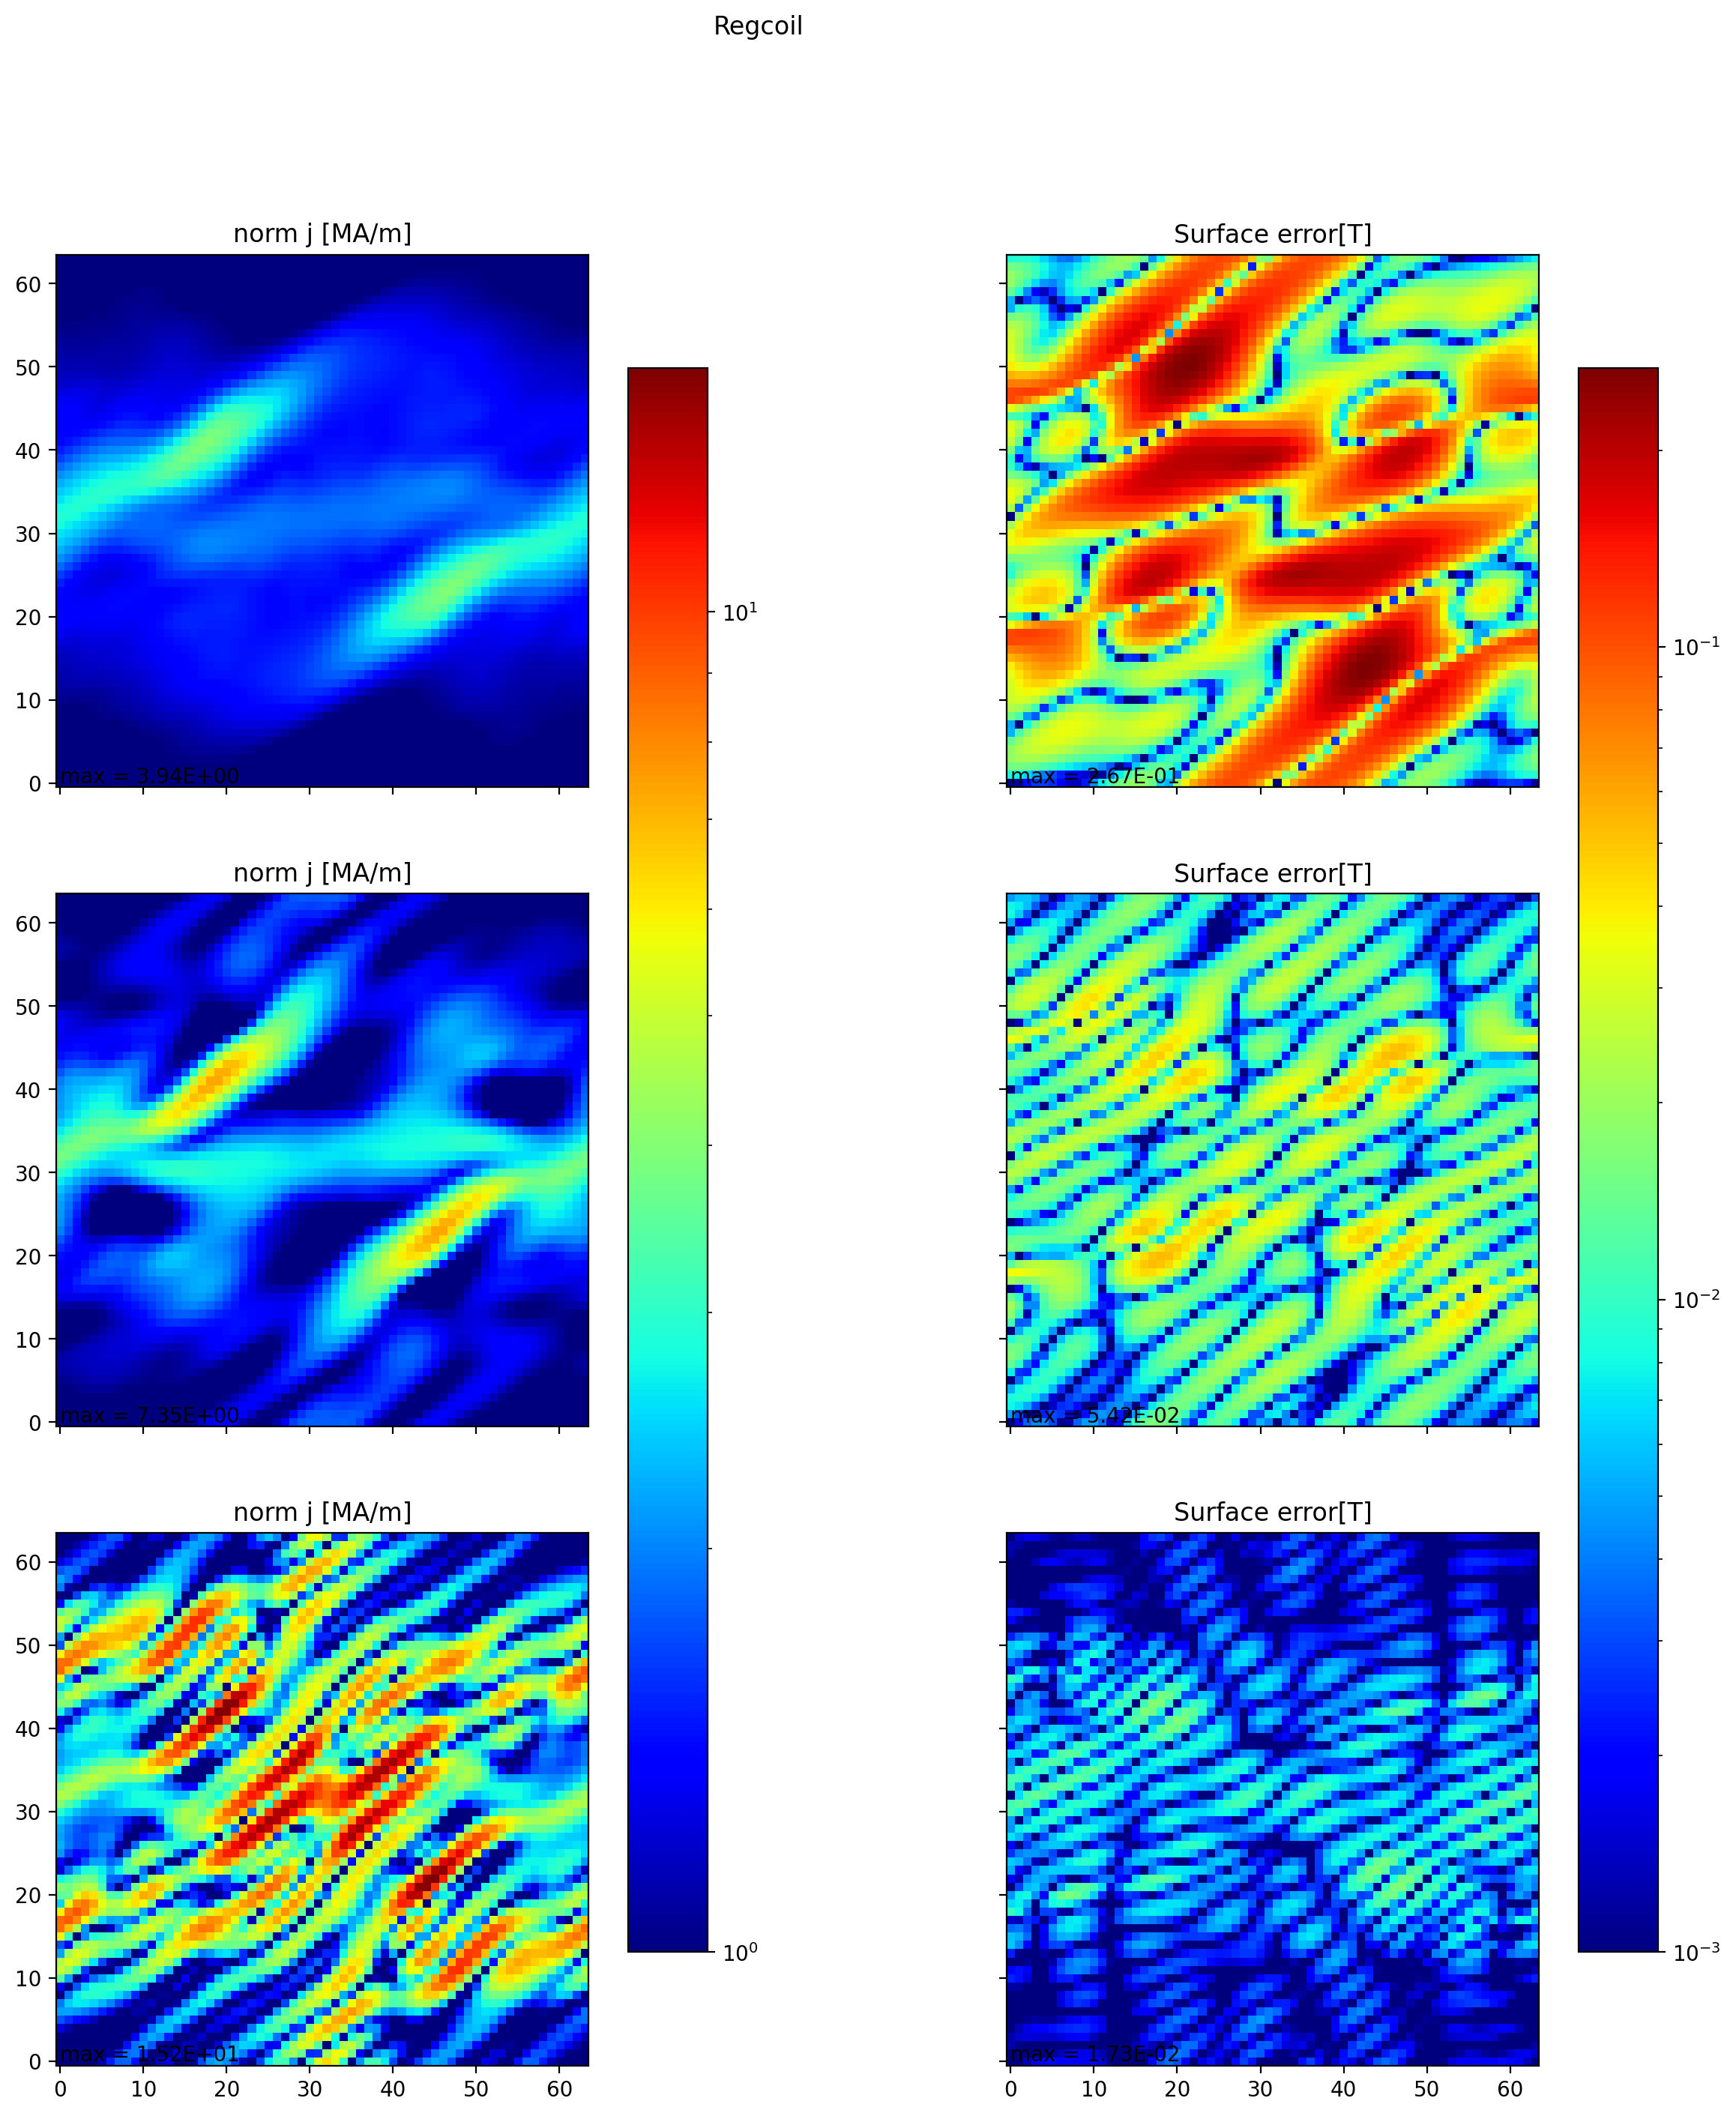

In [9]:
lst_title=['norm j [MA/m]','Surface error[T]']*3
Nr = 3
Nc = 2
cmap = "jet"
suptitle='Regcoil'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs[:,0],np.array(lst_data_sol[0::2])/1e6,lst_title[::2],suptitle,cmap,vmin=1)
plot_jupyter(fig,axs[:,1],np.abs(lst_data_sol[1::2]),lst_title[1::2],suptitle,cmap,vmin=1e-3)

In [11]:
import importlib
importlib.reload(avg_laplace_force)
avg=avg_laplace_force.Avg_laplace_force(cws)
sol_C,sol_S=vector_field_on_TS.Div_free_vector_field_on_TS.array_coeff_to_CS(sol2,phisize)
coeff=(G,I,sol_C,sol_S)
laplace_array=avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)

In [12]:
import importlib
importlib.reload(avg_laplace_force)
avg=avg_laplace_force.Avg_laplace_force(cws)

In [13]:
%timeit f_ref=avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)

9.35 s ± 58.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
import time
lst_theta=range(ntheta_coil-1)
n=6
step=math.ceil((ntheta_coil-1)/n)
blocks=[lst_theta[i:i + step] for i in range(0, len(lst_theta), step)]
def f(x):
    return avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff,x)
t0=time.time()
with Pool(n) as p:
    res=p.map(f, blocks)
t1=time.time()
print(t1-t0)
ares=np.concatenate(res,axis=0)

2.0516674518585205


In [15]:
djdc=get_djdc_naif(Phisize,cws.dpsidu,cws.dpsidv,cws.dS,cws.grid)

100%|██████████| 168/168 [00:00<00:00, 198.86it/s]


In [16]:
%timeit avg.grad_f_laplace(ntheta_coil-1,nzeta_coil-1,coeff,djdc,[0])
%load_ext line_profiler
%load_ext memory_profiler

5.93 s ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
import importlib
importlib.reload(avg_laplace_force)
avg=avg_laplace_force.Avg_laplace_force(cws)
avg.grad_f_laplace(ntheta_coil-1,nzeta_coil-1,coeff,djdc,[0])
%lprun -u 1 -f avg_laplace_force.aux_grad_extended avg.grad_f_laplace(ntheta_coil-1,nzeta_coil-1,coeff,djdc,[0,1,2])

Timer unit: 1 s

Total time: 17.7663 s
File: ./main/avg_laplace_force.py
Function: aux_grad_extended at line 419

Line #      Hits         Time  Per Hit   % Time  Line Contents
   419                                           def aux_grad_extended(lst_rot,Px,Py,Pz,div_xe_uv,g_upper,dpsidu,dpsidv,surf_n,surf_normal,dS,j2,param,dj2,j1,djdc,full_pull_back,lst_theta,lst_zeta,dj2_,Np):
   420         1          0.0      0.0      0.0      (lu,lv,lc,d1,d2)=param
   421         1          0.0      0.0      0.0      lz=len(lst_zeta)
   422         1          0.0      0.0      0.0      djdc_r=np.moveaxis(djdc,0,2)
   423         1          0.0      0.0      0.0      laplace_array_full=np.zeros((Np,len(lst_theta),len(lst_zeta),lc,3))
   424                                               #initizlization of the arrays :
   425         1          0.0      0.0      0.0      j1y_=np.zeros((lc,3))
   426         1          0.0      0.0      0.0      pi_xjy_uv_=np.zeros((lu,lv,lc,2))
   427         1    

In [24]:
%memit avg.grad_f_laplace(ntheta_coil-1,nzeta_coil-1,coeff,djdc,[0])

peak memory: 5095.45 MiB, increment: 0.08 MiB


In [29]:
import time
lst_theta=range(ntheta_coil-1)
n=6
step=math.ceil((ntheta_coil-1)/n)
blocks=[lst_theta[i:i + step] for i in range(0, len(lst_theta), step)]
blocks=[[0,1,2]]*n 
def f(x):
    return avg.grad_f_laplace(ntheta_coil-1,nzeta_coil-1,coeff,djdc,x)
t0=time.time()
with Pool(n) as p:
    res=p.map(f, blocks)
t1=time.time()
print(t1-t0)
ares=np.concatenate(res,axis=0)

79.76375603675842


In [30]:
import scipy

In [26]:
%prun avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)

         1488040 function calls (1389675 primitive calls) in 9.497 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    12288    6.072    0.000    6.072    0.000 avg_laplace_force.py:908(aux)
    24585    1.110    0.000    1.110    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
    24588    0.990    0.000    1.334    0.000 function_base.py:802(gradient)
    12291    0.325    0.000    1.744    0.000 avg_laplace_force.py:63(div)
        1    0.235    0.235    9.497    9.497 avg_laplace_force.py:221(f_laplace_optimized)
159851/61486    0.138    0.000    2.791    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    24588    0.100    0.000    0.100    0.000 {method 'repeat' of 'numpy.ndarray' objects}
   135271    0.093    0.000    0.093    0.000 {built-in method numpy.array}
    12292    0.077    0.000    0.225    0.000 shape_base.py:1171(tile)
    49176    0.050    0.000    0.091    0

In [18]:
%timeit laplace_array,avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff)

798 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
numba.set_num_threads(1)#to compare on 1 thread
eps=1e-3
%timeit compute_L_eps(cws,coeff,eps)

159 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
import importlib
importlib.reload(avg_laplace_force)
avg=avg_laplace_force.Avg_laplace_force(cws)
np.testing.assert_almost_equal(laplace_array,avg.f_laplace_optimized(ntheta_coil-1,nzeta_coil-1,coeff,coeff))

In [25]:
laplace_norm=np.linalg.norm(laplace_array,axis=2)
laplace_normal=np.sum(-1*cws.normal[:-1,:-1,:]*laplace_array,axis=2)
laplace_tangent=laplace_array-laplace_normal[:,:,np.newaxis]*(-1*cws.normal[:-1,:-1,:])
laplace_norm_tangent=np.linalg.norm(laplace_tangent,axis=2)

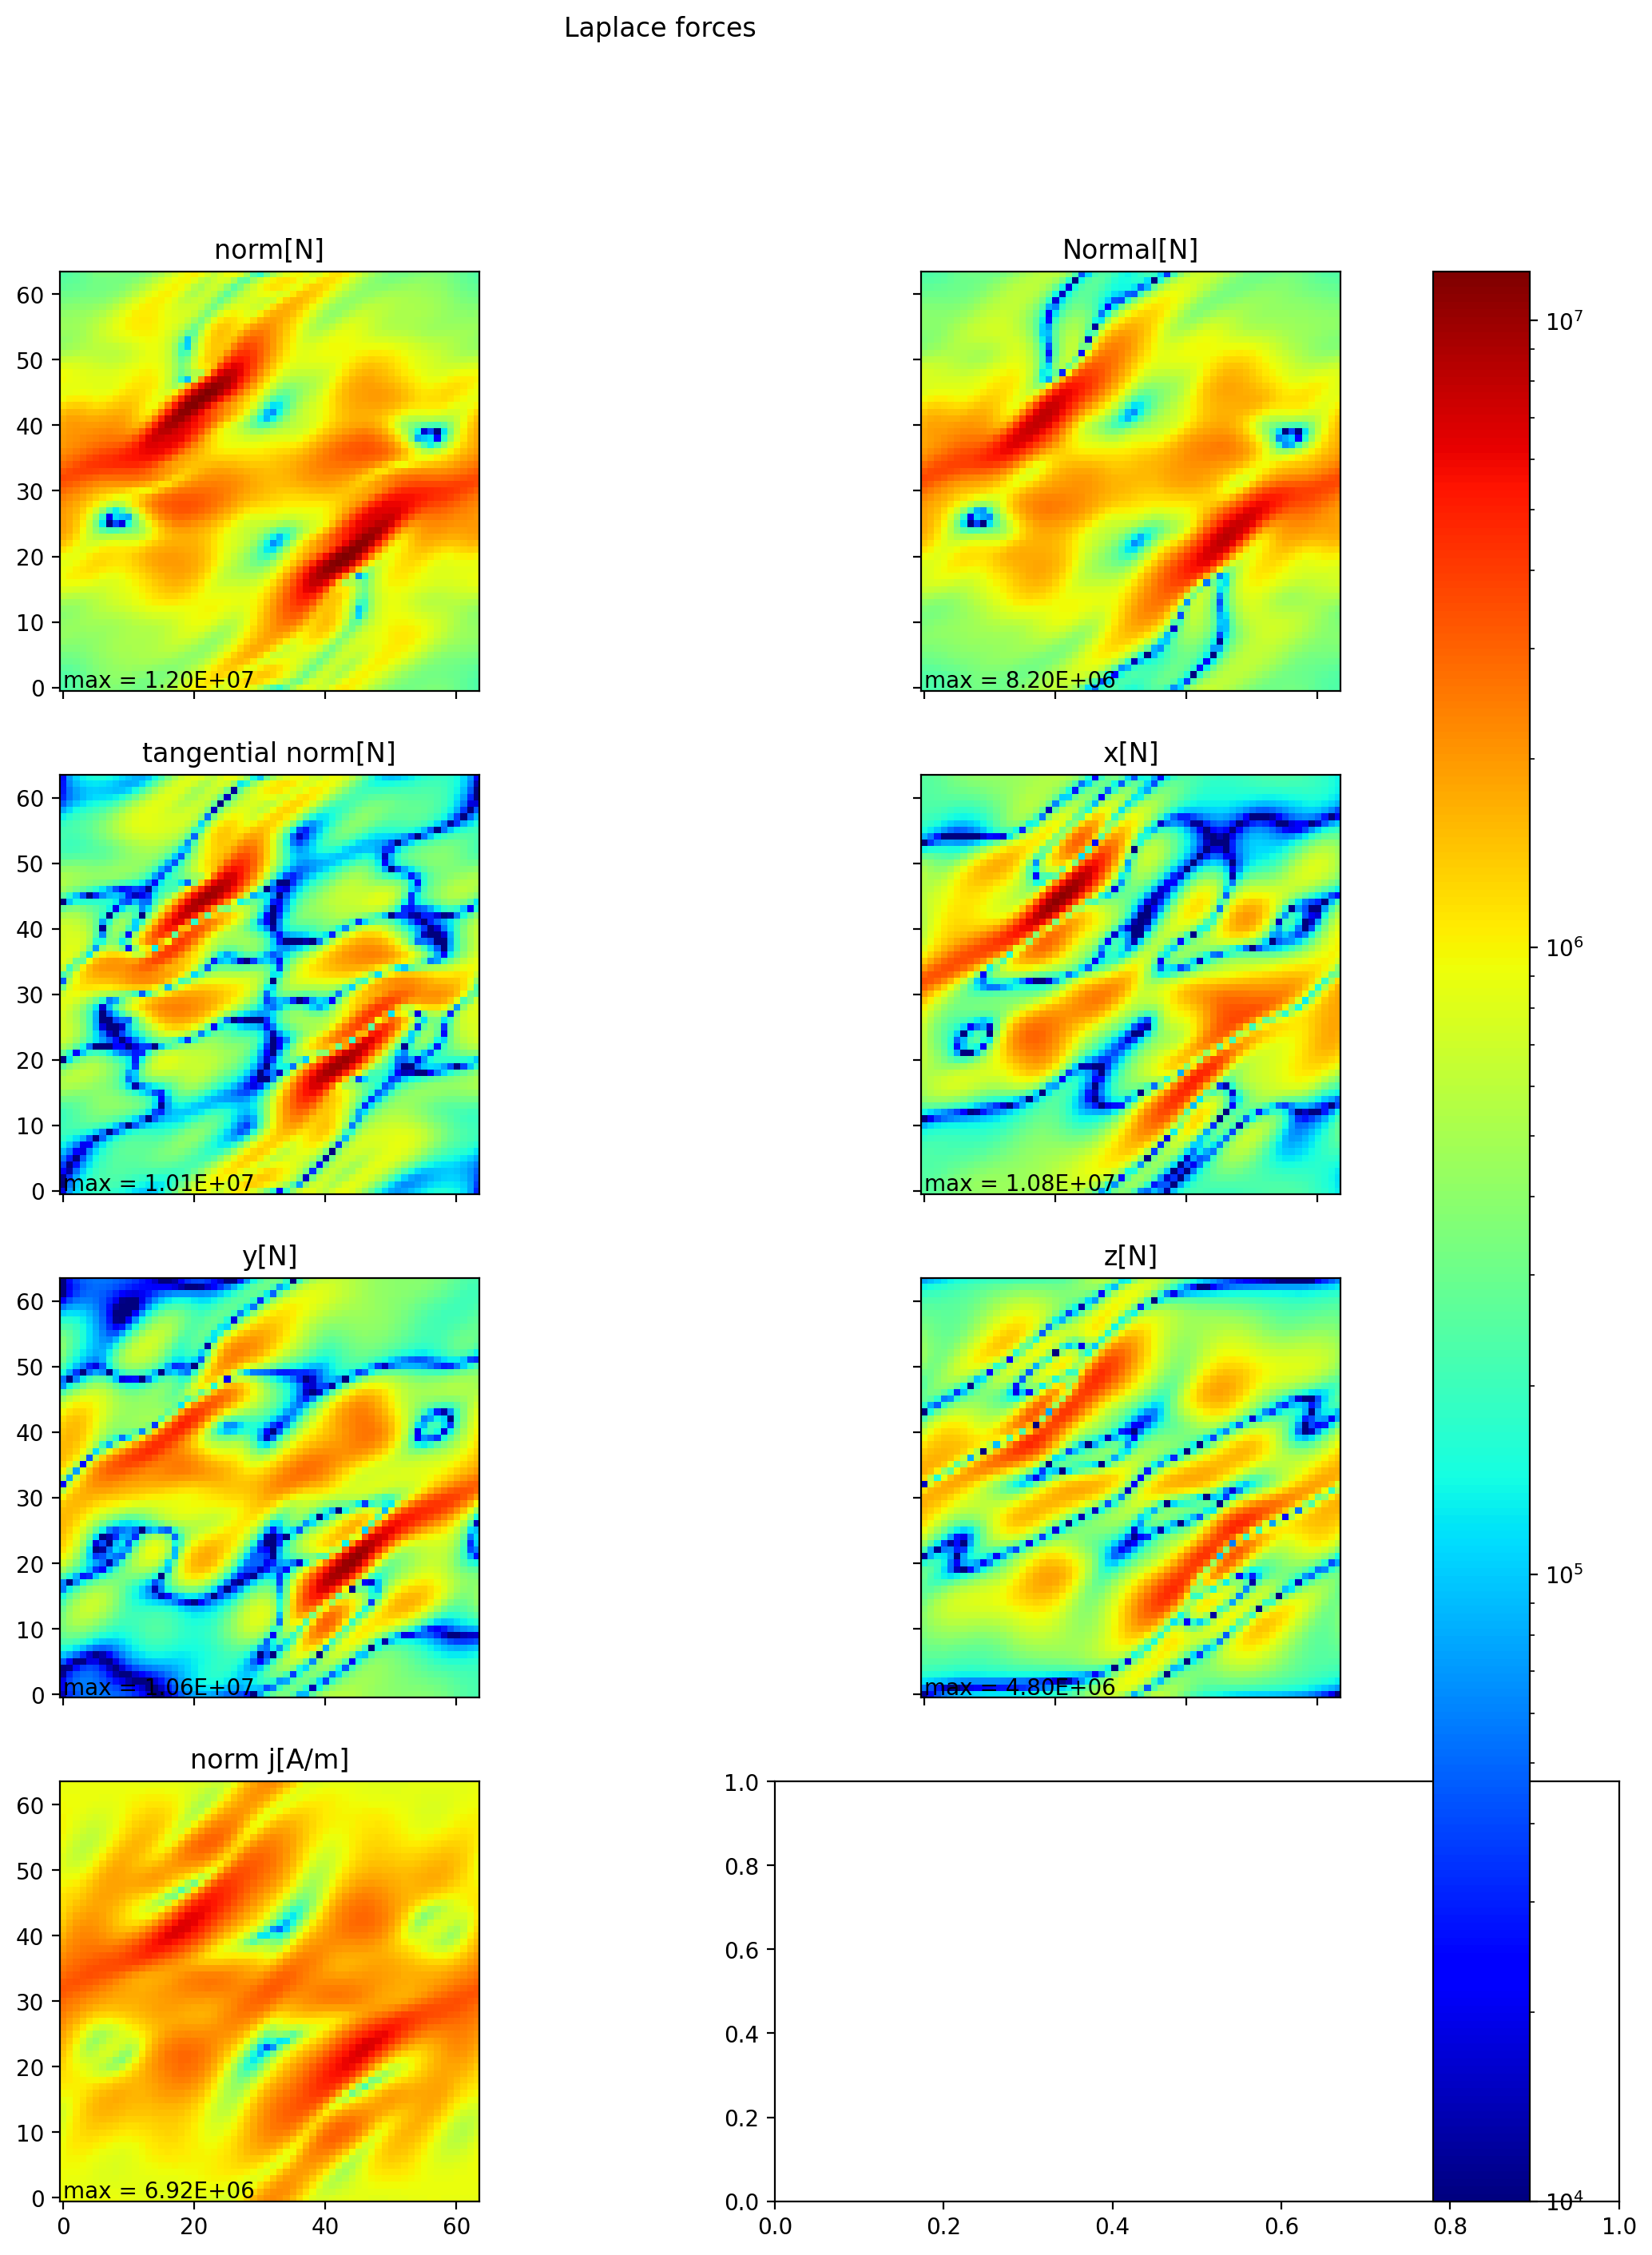

In [228]:
lst_data=np.abs(np.array([laplace_norm,laplace_normal,laplace_norm_tangent,laplace_array[:,:,0],laplace_array[:,:,1],laplace_array[:,:,2],lst_data_sol[2]]))
lst_title=['norm[N]','Normal[N]','tangential norm[N]','x[N]','y[N]','z[N]','norm j[A/m]']
Nr = 4
Nc = 2
cmap = "jet"
suptitle='Laplace forces'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs.flatten()[:-1],lst_data,lst_title,suptitle,cmap,vmin=1e4)

In [20]:
sol_C,sol_S=vector_field_on_TS.Div_free_vector_field_on_TS.array_coeff_to_CS(sol2,Phisize)
coeff=(G,I,sol_C,sol_S)
eps=1e-6
laplace_array_eps=compute_L_eps(cws,coeff,eps)

laplace_aux_eps=compute_aux(cws,laplace_array_eps)
#[laplace_norm,laplace_normal,laplace_tangent,laplace_norm_tangent]

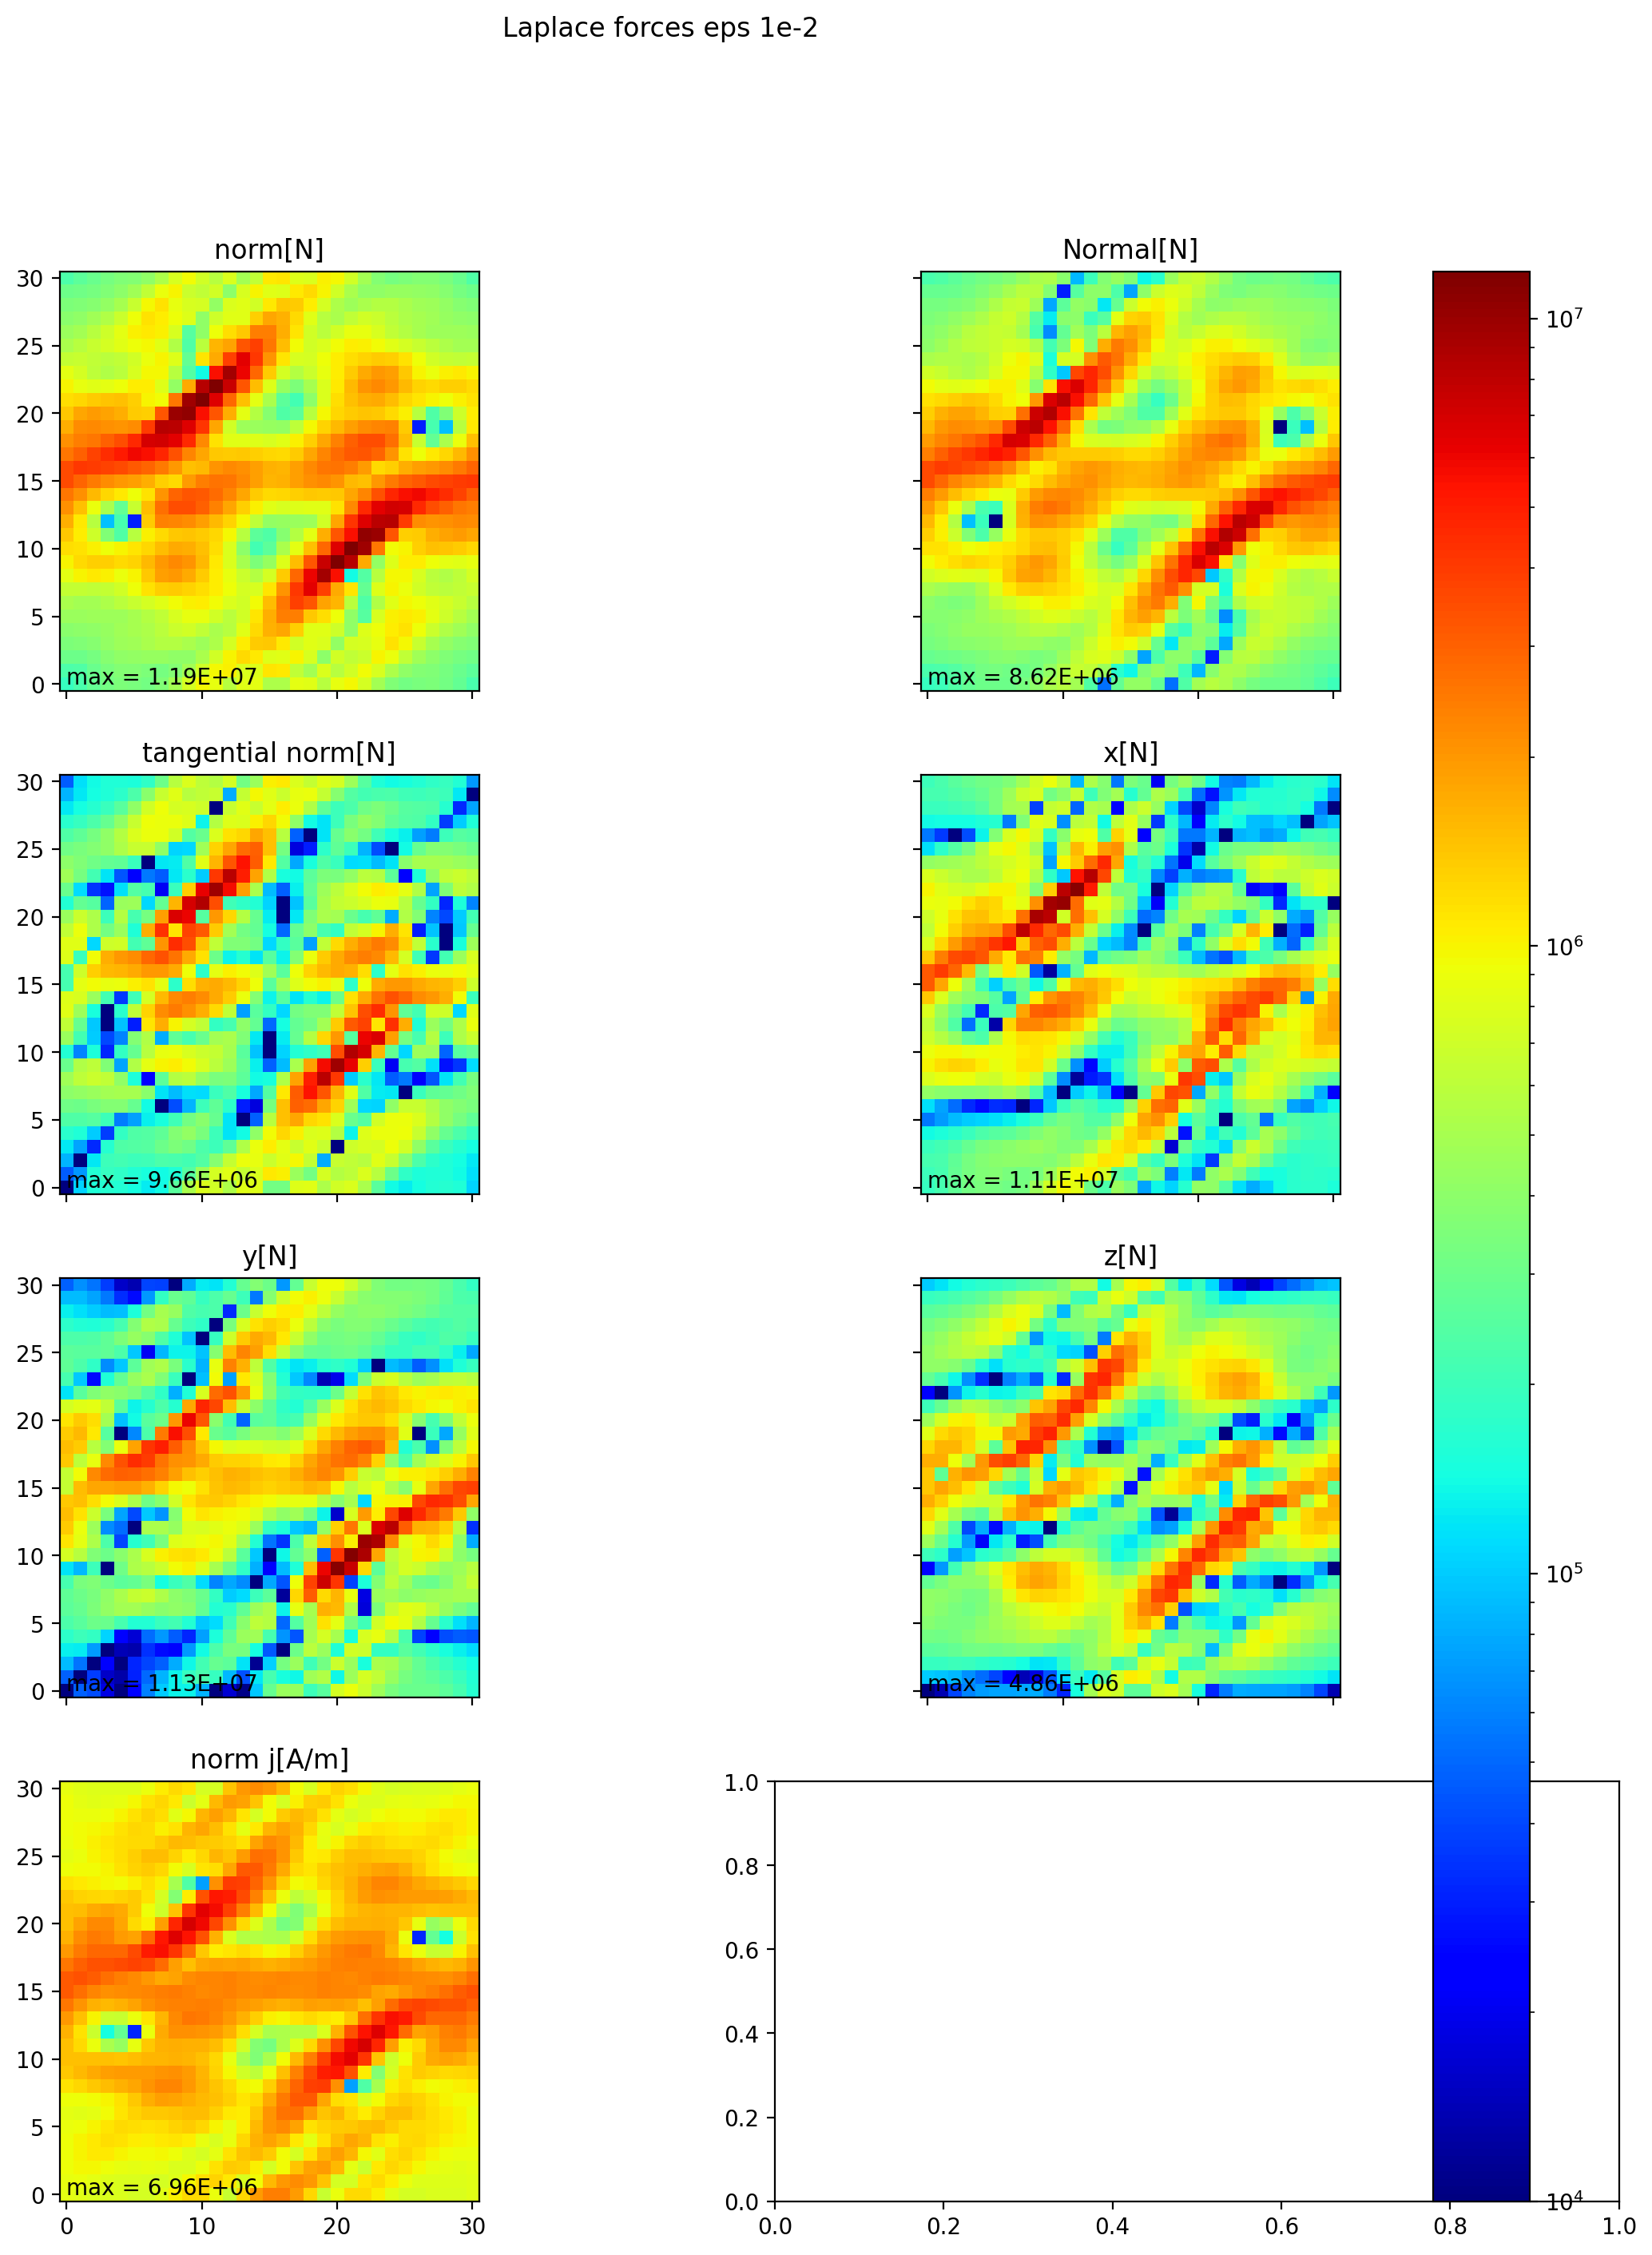

In [21]:
lst_data=np.abs(np.array([laplace_aux_eps[0],laplace_aux_eps[1],laplace_aux_eps[3],laplace_array_eps[:,:,0],laplace_array_eps[:,:,1],laplace_array_eps[:,:,2],lst_data_sol[2]]))
lst_title=['norm[N]','Normal[N]','tangential norm[N]','x[N]','y[N]','z[N]','norm j[A/m]']
Nr = 4
Nc = 2
cmap = "jet"
suptitle='Laplace forces eps 1e-2'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs.flatten()[:-1],lst_data,lst_title,suptitle,cmap,vmin=1e4)

In [23]:
lst_data=np.abs(np.array([laplace_normal,laplace_normal_eps,laplace_normal_eps2,laplace_normal_eps_h,laplace_normal_eps2_h]))
lst_title=['our method','1e-2','1e-3','1e-2','1e-3']
Nr = 4
Nc = 2
cmap = "jet"
suptitle='Laplace forces'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs.flatten()[:5],lst_data,lst_title,suptitle,cmap,vmin=1e4)

NameError: name 'laplace_normal' is not defined

Higher res

In [ ]:
ntheta_coil_h   = 128+1
nzeta_coil_h   = 128+1
cws_h=toroidal_surface.Toroidal_surface(W7x_pathfile=path_cws,nbpts=(ntheta_coil_h,nzeta_coil_h),Np=3)
div_free_h=vector_field_on_TS.Div_free_vector_field_on_TS(cws_h)

In [ ]:
import importlib
importlib.reload(avg_laplace_force)
avg_h=avg_laplace_force.Avg_laplace_force(cws_h)
eps=1e-5
laplace_array_eps_h=np.zeros((ntheta_coil_h-1,nzeta_coil_h-1,3))
laplace_array_eps_h=avg_h.L_eps_optimized(ntheta_coil_h-1,nzeta_coil_h-1,coeff,eps)

laplace_norm_eps_h=np.linalg.norm(laplace_array_eps_h,axis=2)
laplace_normal_eps_h=np.sum(-1*cws_h.normal[:-1,:-1,:]*laplace_array_eps_h,axis=2)
laplace_tangent_eps_h=laplace_array_eps_h-laplace_normal_eps_h[:,:,np.newaxis]*(-1*cws_h.normal[:-1,:-1,:])
laplace_norm_tangent_eps_h=np.linalg.norm(laplace_tangent_eps_h,axis=2)

lst_data=np.abs(np.array([laplace_norm_eps_h,laplace_normal_eps_h,laplace_norm_tangent_eps_h,laplace_array_eps_h[:,:,0],laplace_array_eps_h[:,:,1],laplace_array_eps_h[:,:,2],lst_data_sol[2]]))
lst_title=['norm[N]','Normal[N]','tangential norm[N]','x[N]','y[N]','z[N]','norm j[A/m]']
Nr = 4
Nc = 2
cmap = "jet"
suptitle='Laplace forces eps 1e-2'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs.flatten()[:-1],lst_data,lst_title,suptitle,cmap,vmin=1e4)

In [ ]:
import importlib
importlib.reload(avg_laplace_force)
avg_h=avg_laplace_force.Avg_laplace_force(cws_h)
eps=1e-3
laplace_array_eps2_h=np.zeros((ntheta_coil_h-1,nzeta_coil_h-1,3))
for i in tqdm(range(ntheta_coil_h-1)):
    for j in range(nzeta_coil_h-1):
        laplace_array_eps2_h[i,j,:]=avg_h.L_eps(i,j,eps,coeff)

In [ ]:
laplace_norm_eps2_h=np.linalg.norm(laplace_array_eps2_h,axis=2)
laplace_normal_eps2_h=np.sum(-1*cws_h.normal[:-1,:-1,:]*laplace_array_eps2_h,axis=2)
laplace_tangent_eps2_h=laplace_array_eps2_h-laplace_normal_eps2_h[:,:,np.newaxis]*(-1*cws_h.normal[:-1,:-1,:])
laplace_norm_tangent_eps2_h=np.linalg.norm(laplace_tangent_eps2_h,axis=2)

In [ ]:
lst_data=np.abs(np.array([laplace_norm_eps2_h,laplace_normal_eps2_h,laplace_norm_tangent_eps2_h,laplace_array_eps2_h[:,:,0],laplace_array_eps2_h[:,:,1],laplace_array_eps2_h[:,:,2],lst_data_sol[2]]))
lst_title=['norm[N]','Normal[N]','tangential norm[N]','x[N]','y[N]','z[N]','norm j[A/m]']
Nr = 4
Nc = 2
cmap = "jet"
suptitle='Laplace forces eps 1e-3'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs.flatten()[:-1],lst_data,lst_title,suptitle,cmap,vmin=1e4)

In [ ]:
import importlib
importlib.reload(avg_laplace_force)
eps=1e-4
laplace_array_eps3=np.zeros((ntheta_coil-1,nzeta_coil-1,3))
for i in tqdm(range(ntheta_coil-1)):
    for j in range(nzeta_coil-1):
        laplace_array_eps3[i,j,:]=avg.L_eps(i,j,eps,coeff)

In [ ]:
import importlib
importlib.reload(avg_laplace_force)
avg=avg_laplace_force.Avg_laplace_force(cws)
eps=1e-4
laplace_array_eps3_v2=avg.L_eps_optimized(ntheta_coil-1,nzeta_coil-1,coeff,eps)

In [ ]:
laplace_norm_eps3=np.linalg.norm(laplace_array_eps3,axis=2)
laplace_normal_eps3=np.sum(-1*cws.normal[:-1,:-1,:]*laplace_array_eps3,axis=2)
laplace_tangent_eps3=laplace_array_eps3-laplace_normal_eps3[:,:,np.newaxis]*(-1*cws.normal[:-1,:-1,:])
laplace_norm_tangent_eps3=np.linalg.norm(laplace_tangent_eps3,axis=2)

In [ ]:
lst_data=np.abs(np.array([laplace_norm_eps3,laplace_normal_eps3,laplace_norm_tangent_eps3,laplace_array_eps3[:,:,0],laplace_array_eps3[:,:,1],laplace_array_eps3[:,:,2],lst_data_sol[2]]))
lst_title=['norm[N]','Normal[N]','tangential norm[N]','x[N]','y[N]','z[N]','norm j[A/m]']
Nr = 4
Nc = 2
cmap = "jet"
suptitle='Laplace forces eps 1e-4'
fig, axs = plt.subplots(Nr, Nc)
plot_jupyter(fig,axs.flatten()[:-1],lst_data,lst_title,suptitle,cmap,vmin=1e4)